# Predicting ENSO
### Source: Libby Barnes
[![Latest release](https://badgen.net/github/release/Naereen/Strapdown.js)](https://github.com/eabarnes1010/ml_tutorial_csu/tree/main/code/)
### Input*Gradient Code by: Antonios Mamalakis
### Edited by: Kirsten Mayer & Will Chapman
Here we are training a classifier to predict whether an El Nino or La Nina event is occuring. The input is a map of global SST, and the output is a classification of either 1=El Nino or 0=La Nino

In [33]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import matplotlib as mpl
import scipy

import tensorflow as tf

# set seeds
random_seed = 36
np.random.seed(random_seed)
tf.random.set_seed(int(random_seed))

import cartopy
#nice figures
mpl.rcParams['figure.facecolor'] = 'white'
mpl.rcParams['figure.dpi']= 150
mpl.rcParams['font.size'] = 12

import scipy as sp
import scipy.ndimage

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib import ticker


### Load Libraries

## Other Functions

In [28]:
def smooth_it(Patty):
    sigma_y = 1.5
    sigma_x = 1.5
    sigma = [sigma_y, sigma_x]
    y = sp.ndimage.gaussian_filter(Patty, sigma, mode='constant')
    return y

### Input*Gradient Function

In [4]:
def get_gradients(inputs, top_pred_idx=None):
    """Computes the gradients of outputs w.r.t input image.

    Args:
        inputs: 2D/3D/4D matrix of samples
        top_pred_idx: (optional) Predicted label for the x_data
                      if classification problem. If regression,
                      do not include.

    Returns:
        Gradients of the predictions w.r.t img_input
    """
    inputs = tf.cast(inputs, tf.float32)

    with tf.GradientTape() as tape:
        tape.watch(inputs)
        
        # Run the forward pass of the layer and record operations
        # on GradientTape.
        preds = model(inputs, training=False)  
        
        # For classification, grab the top class
        if top_pred_idx is not None:
            preds = preds[:, top_pred_idx]
        
    # Use the gradient tape to automatically retrieve
    # the gradients of the trainable variables with respect to the loss.        
    grads = tape.gradient(preds, inputs)
    return grads

## Preprocessing
Load in the data from the netcdf. This is ERSSTv5 which has been deseasoned, linearly detrended, and has a 5 month lookback running mean applied. From this, we can calculate the Nino3.4 index.

In [5]:
filename = 'ERSSTv5_deseasoneddetrended_5monthrunningmean_1950-2021.nc' 
sstds = xr.open_dataset(filename,decode_times=False)
sst = sstds.sst
sst = sst.where((sst.lat <= 30) & (sst.lat >= -30), drop=True)
lat = np.asarray(sst.lat)
lon = np.asarray(sst.lon)
time = sstds.time

ninolat1 = -5
ninolat2 = 5
ninolon1 = 190
ninolon2 = 240

sstnino = np.asarray(sst.sel(lat=slice(ninolat1,ninolat2),lon=slice(ninolon1,ninolon2)))
nino34 = np.nanmean(sstnino,axis=(1,2))

## Data preparation
First, we need to include only samples where nino event is occuring (i.e. nino3.4>0.5 or nino3.4<-0.5). Then, we will divide the sst input and nino3.4 output into training, validation and testing chunks.

In [6]:
nino_occur = nino34[(nino34>0.5) | (nino34<-0.5)] # only samples where nino event occurs
nino_occur[nino_occur>0.5] = 1 # make into categorical format, 1 for El Nino and 0 for La Nina
nino_occur[nino_occur<0.5] = 0
nino_occur = tf.keras.utils.to_categorical(nino_occur) # format accepted by NN
sizefull = nino_occur.shape[0]

train_val_test = [0.7,0.85,1] # set train/val/test fraction

sst = np.asarray(sst)
sizesst = sst.shape
sstnino_occur = sst[(nino34>0.5) | (nino34<-0.5),:,:] # grab sst samples where nino occurs
sstnino_occur = np.reshape(sstnino_occur,(sizefull,sizesst[1]*sizesst[2])) # reshape latxlon to vectors

trainind = range(int(train_val_test[0]*sizefull))
valind = range(int(train_val_test[0]*sizefull),int(train_val_test[1]*sizefull))
testind = range(int(train_val_test[1]*sizefull),int(train_val_test[2]*sizefull))

# divide into training/validation/testing
sst_train = sstnino_occur[trainind,:]
sst_val = sstnino_occur[valind,:]
sst_test = sstnino_occur[testind,:]

nino_train  = nino_occur[trainind]
nino_val = nino_occur[valind]
nino_test = nino_occur[testind]

In [7]:
sst_std = np.std(sst_train,axis=0) # standardized by the TRAINING STD

sst_train = np.divide(sst_train,sst_std)
sst_train[np.isnan(sst_train)] = 0 # set all nans to zeros (they are learned to be ignored)
sst_val = np.divide(sst_val,sst_std)
sst_val[np.isnan(sst_val)] = 0
sst_test = np.divide(sst_test,sst_std)
sst_test[np.isnan(sst_test)] = 0

## Load Trained Neural Network

In [8]:
model = tf.keras.models.load_model('saved_model/ENSOmodel.h5')

2023-05-31 13:42:20.342870: E tensorflow/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-05-31 13:42:20.342909: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (crhtc39): /proc/driver/nvidia/version does not exist
2023-05-31 13:42:20.345258: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Plot SST composites of correct predictions
How does the model do on unseen data?

In [9]:
nino_pred = model.predict(sst_test) # make predictions for test data

nino_pred = np.argmax(nino_pred,axis=1)
nino_true = np.argmax(nino_test,axis=1)

modelcorr = nino_pred==nino_true
nmodelcorr = modelcorr[modelcorr].shape[0]
ntest = nino_true.shape[0]
print('Model accuracy on testing is %f%%' %(100*nmodelcorr/ntest))

3/3 [==============================] - 0s 2ms/step
Model accuracy on testing is 100.000000%


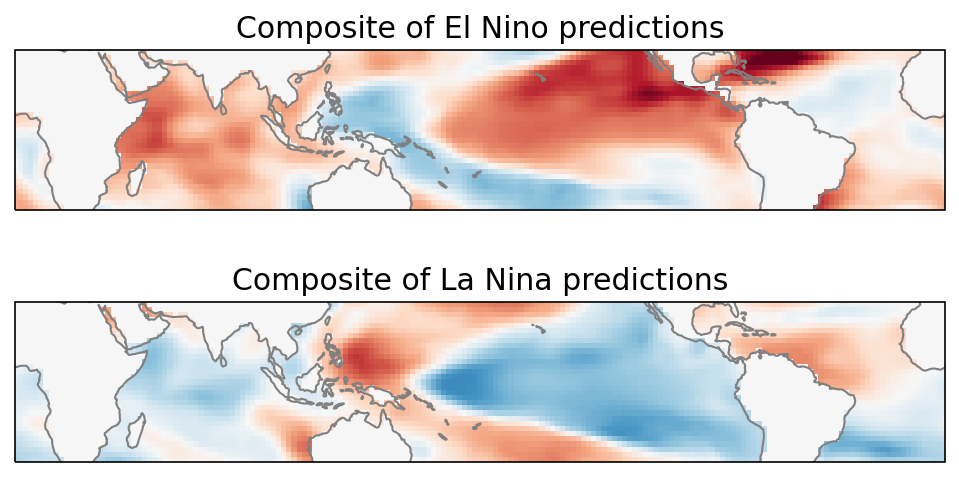

In [10]:
elninopred = (nino_pred==1)
laninapred = (nino_pred==0)

elnino_sst = sst_test[elninopred,:]
elnino_sst = np.reshape(elnino_sst,(elnino_sst.shape[0],sizesst[1],sizesst[2]))
lanina_sst = sst_test[laninapred,:]
lanina_sst = np.reshape(lanina_sst,(lanina_sst.shape[0],sizesst[1],sizesst[2]))

elninoplot = np.mean(elnino_sst,axis=0)
laninaplot = np.mean(lanina_sst,axis=0)

projection = ccrs.PlateCarree(central_longitude=180)
transform = ccrs.PlateCarree()

plt.figure(figsize=(8,4))

ax1=plt.subplot(2,1,1,projection=projection)
ax1.pcolormesh(lon,lat,elninoplot,vmin=-2,vmax=2,cmap='RdBu_r',transform=transform)
ax1.coastlines(color='gray')
plt.title('Composite of El Nino predictions')

ax2=plt.subplot(2,1,2,projection=projection)
ax2.pcolormesh(lon,lat,laninaplot,vmin=-2,vmax=2,cmap='RdBu_r',transform=transform)
ax2.coastlines(color='gray')
plt.title('Composite of La Nina predictions')

plt.show()

## Input * Gradient

In [11]:
# Calculate Input*Gradient for correct predictions in each class
nino_pred = model.predict(sst_test) # make predictions for test data

nino_pred = np.argmax(nino_pred,axis=1)
nino_true = np.argmax(nino_test,axis=1)

# find where NN is correct
icorr = nino_pred==nino_true
nino_true_corr = nino_true[icorr]
nino_pred_corr = nino_pred[icorr]

# split correct predictions into each class (0=la nina, 1=el nino)
ilanina_corr = (nino_pred_corr==0)
ielnino_corr = (nino_pred_corr==1)

# grab SST input associated with the correct, class-dependent output
sst_lanina_corr = sst_test[icorr][ilanina_corr]
sst_elnino_corr = sst_test[icorr][ielnino_corr]

# calculate input*gradient (ItG)
## arrays of ItG maps
lanina_ItG_heatmap = np.zeros(shape = (np.shape(sst_lanina_corr)[0],sst_test.shape[-1]))
elnino_ItG_heatmap = np.zeros(shape = (np.shape(sst_elnino_corr)[0],sst_test.shape[-1]))

## arrays of gradient maps
lanina_Grad_heatmap = np.zeros(shape = (np.shape(sst_lanina_corr)[0],sst_test.shape[-1]))
elnino_Grad_heatmap = np.zeros(shape = (np.shape(sst_elnino_corr)[0],sst_test.shape[-1]))

for s,sample in enumerate(sst_lanina_corr):
    lanina_Grad_heatmap[s] = get_gradients((sample.reshape((1,sst_test.shape[-1]))),top_pred_idx=0).numpy()
    lanina_ItG_heatmap[s] = np.multiply(lanina_Grad_heatmap[s],sample.reshape((1,sst_test.shape[-1])))
    
for s,sample in enumerate(sst_elnino_corr):
    elnino_Grad_heatmap[s] = get_gradients((sample.reshape((1,sst_test.shape[-1]))),top_pred_idx=1).numpy()
    elnino_ItG_heatmap[s] = np.multiply(elnino_Grad_heatmap[s],sample.reshape((1,sst_test.shape[-1])))

3/3 [==============================] - 0s 2ms/step


In [16]:
# calculate mean across samples:
lanina_Input_mean = np.reshape(np.mean(sst_lanina_corr,axis=0),(sizesst[1],sizesst[2]))
elnino_Input_mean = np.reshape(np.mean(sst_elnino_corr,axis=0),(sizesst[1],sizesst[2]))

lanina_Grad_meanheatmap = np.reshape(np.mean(lanina_Grad_heatmap,axis=0),(sizesst[1],sizesst[2]))
elnino_Grad_meanheatmap = np.reshape(np.mean(elnino_Grad_heatmap,axis=0),(sizesst[1],sizesst[2]))

lanina_ItG_meanheatmap = np.reshape(np.mean(lanina_ItG_heatmap,axis=0),(sizesst[1],sizesst[2]))
elnino_ItG_meanheatmap = np.reshape(np.mean(elnino_ItG_heatmap,axis=0),(sizesst[1],sizesst[2]))

In [17]:
# smooth gradient to make plot prettier
lanina_Grad_meanheatmap = scipy.ndimage.gaussian_filter(lanina_Grad_meanheatmap, sigma=0.7)
elnino_Grad_meanheatmap = scipy.ndimage.gaussian_filter(elnino_Grad_meanheatmap, sigma=0.7)

lanina_ItG_meanheatmap = scipy.ndimage.gaussian_filter(lanina_ItG_meanheatmap, sigma=0.7)
elnino_ItG_meanheatmap = scipy.ndimage.gaussian_filter(elnino_ItG_meanheatmap, sigma=0.7)

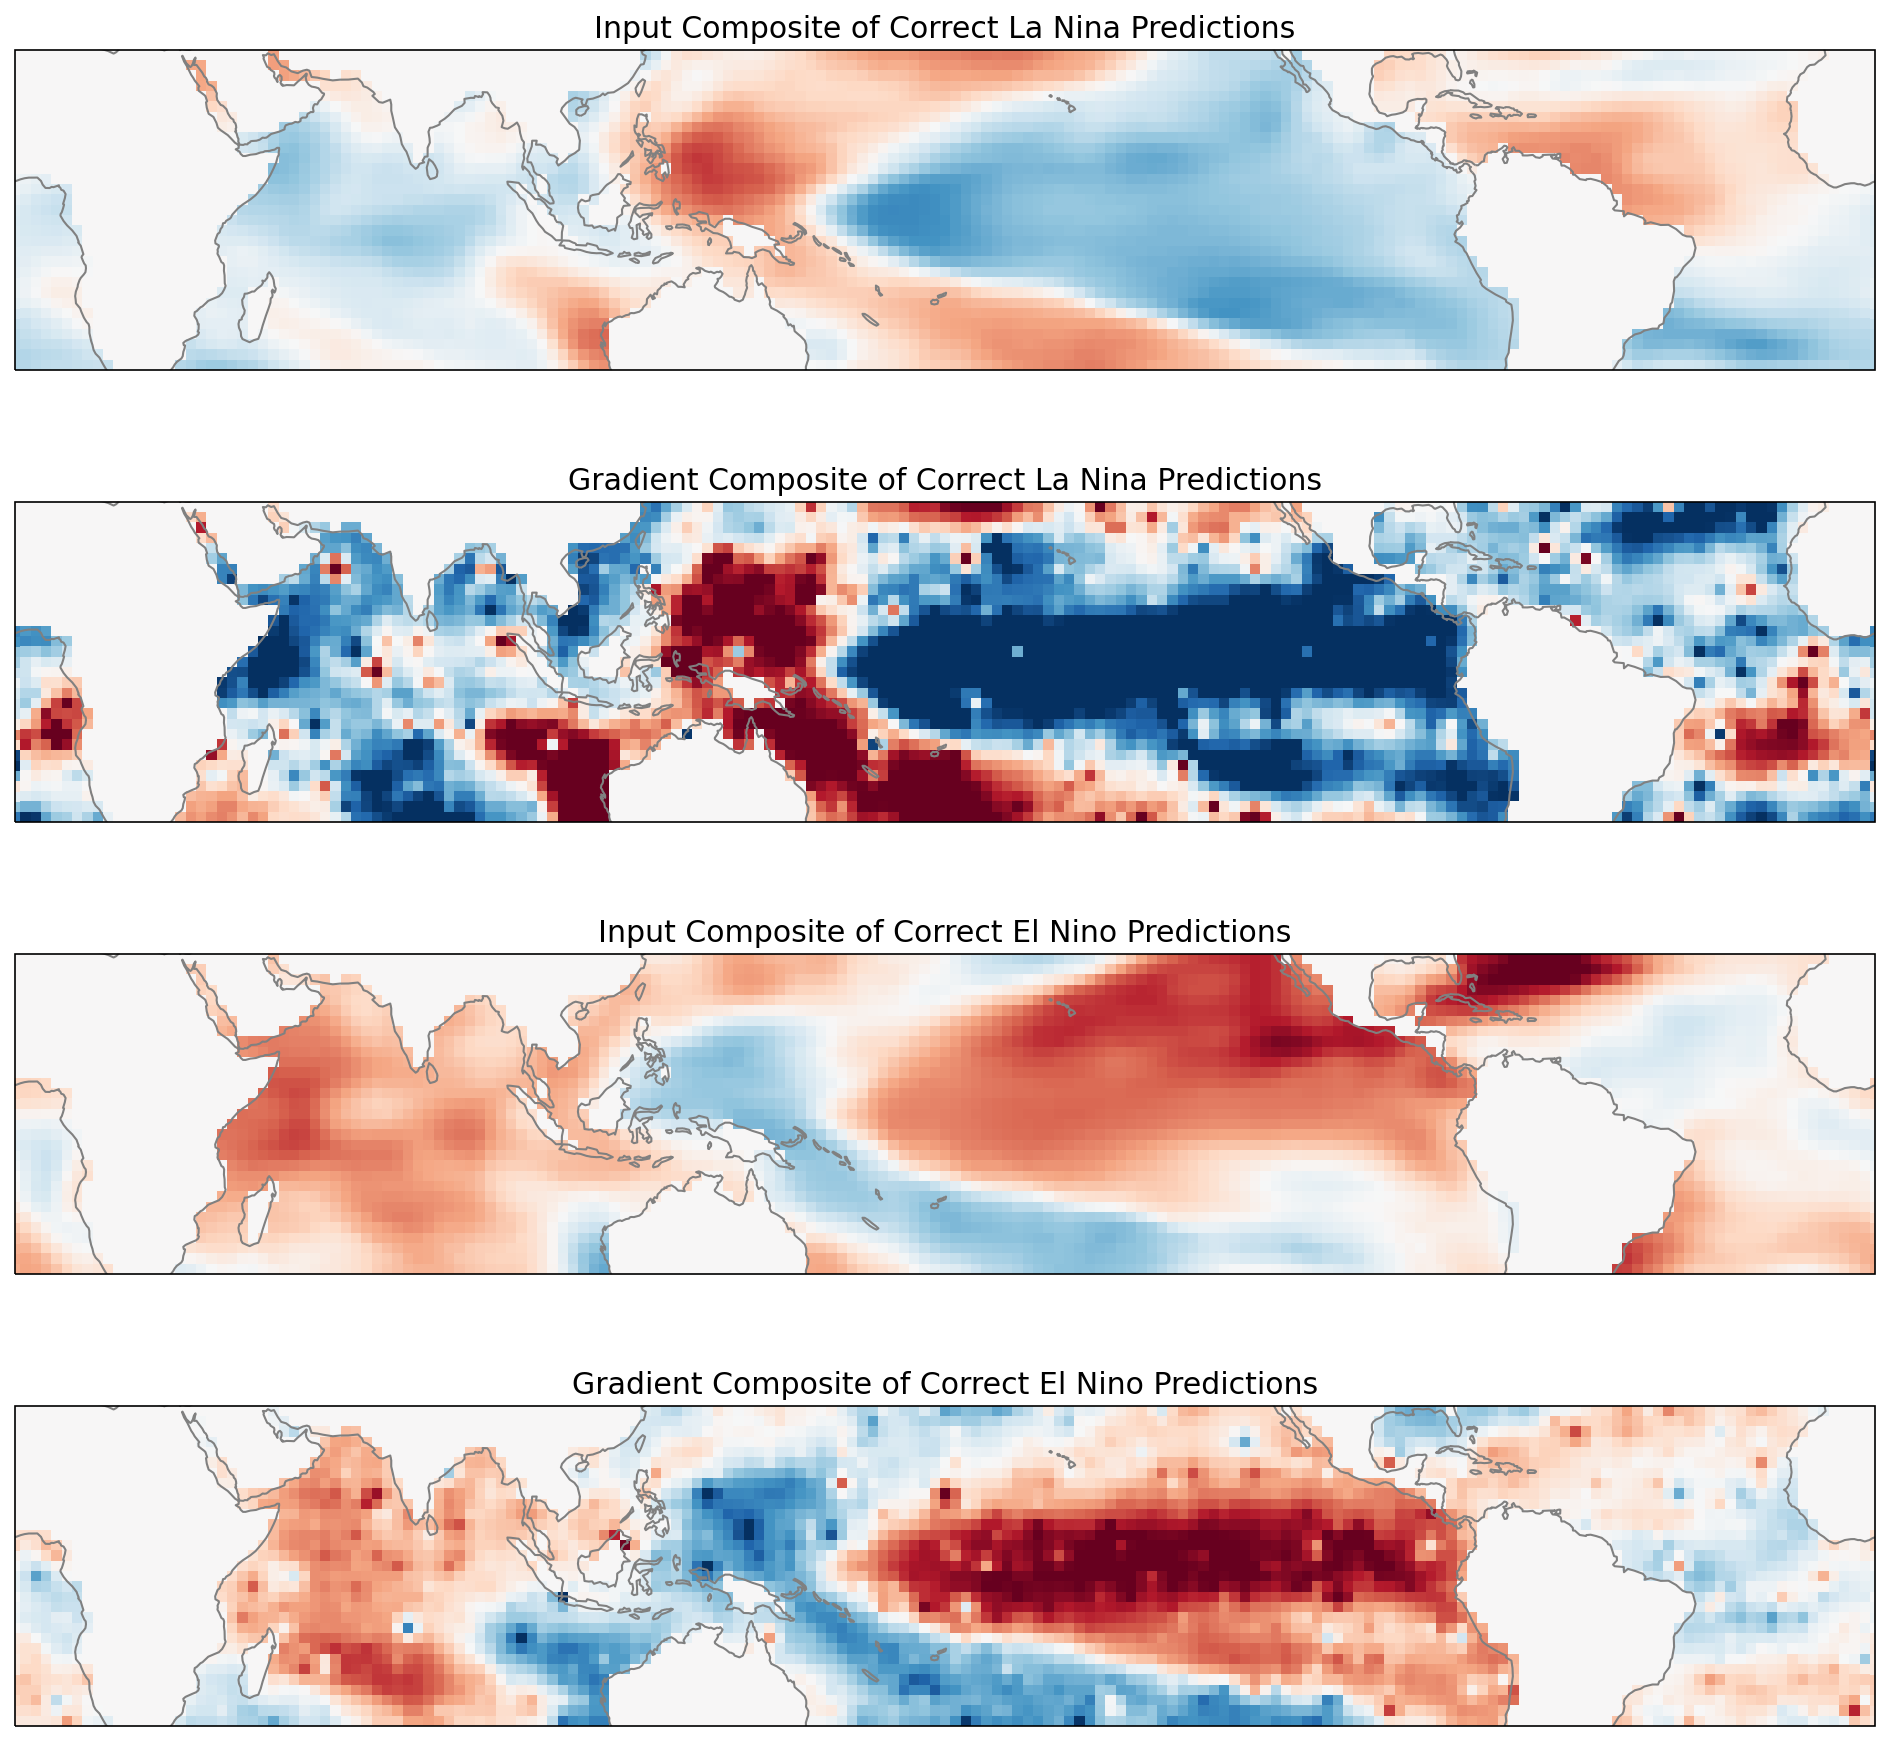

In [18]:
projection = ccrs.PlateCarree(central_longitude=180)
transform = ccrs.PlateCarree()

minval = -0.0001
maxval = 0.0001

plt.figure(figsize=(16,15))

ax1=plt.subplot(4,1,1,projection=projection)
ax1.pcolormesh(lon,lat,lanina_Input_mean,vmin=-2,vmax=2,cmap='RdBu_r',transform=transform)
ax1.coastlines(color='gray')
plt.title('Input Composite of Correct La Nina Predictions')

ax1=plt.subplot(4,1,2,projection=projection)
ax1.pcolormesh(lon,lat,lanina_Grad_meanheatmap*(np.abs(sst[0,:,:].squeeze())>0),vmin=minval,vmax=maxval,cmap='RdBu_r',transform=transform)
ax1.coastlines(color='gray')
plt.title('Gradient Composite of Correct La Nina Predictions')


ax1=plt.subplot(4,1,3,projection=projection)
ax1.pcolormesh(lon,lat,elnino_Input_mean,vmin=-2,vmax=2,cmap='RdBu_r',transform=transform)
ax1.coastlines(color='gray')
plt.title('Input Composite of Correct El Nino Predictions')

ax1=plt.subplot(4,1,4,projection=projection)
ax1.pcolormesh(lon,lat,elnino_Grad_meanheatmap*(np.abs(sst[0,:,:].squeeze())>0)*1,vmin=minval,vmax=maxval,cmap='RdBu_r',transform=transform)
ax1.coastlines(color='gray')
plt.title('Gradient Composite of Correct El Nino Predictions')

plt.show()

## Plot Input*Gradient

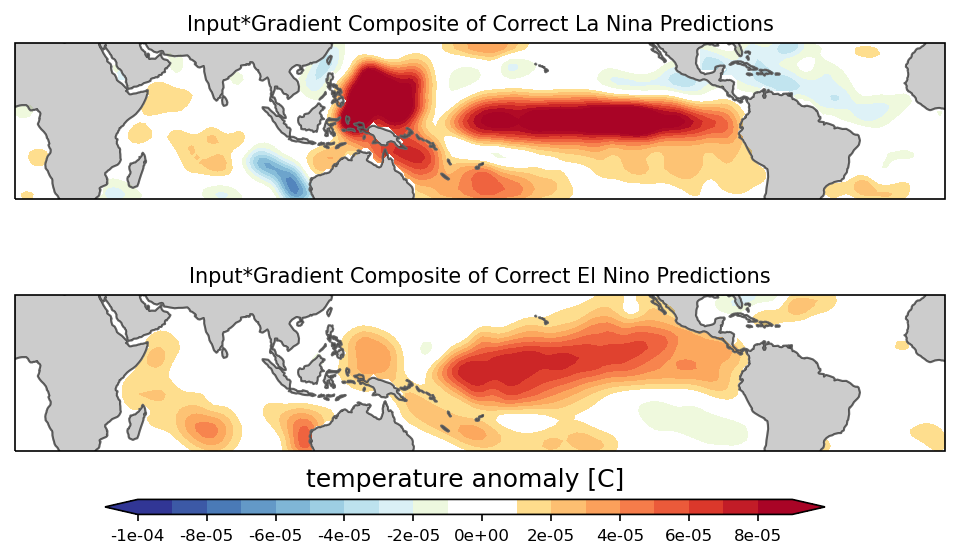

In [50]:
## +++ color map 
cmap = plt.cm.RdYlBu_r
# extract all colors from the Reds map
cmaplist = [cmap(i) for i in range(cmap.N)]
# make the first color entry to be whhite
cmaplist[0] = cmap(0)
 # make the last color entry to be most extreme--
cmaplist[cmap.N-1] = cmap(0.99)
for ii in range(115,151):
    cmaplist[ii]=[1,1,1,1]
# create the new map
cmap = cmap.from_list('My cmap', cmaplist, cmap.N)
# define the contour levels and normalize
clevels=(np.arange(-0.0001,0.0001,0.00001))
norm = mpl.colors.BoundaryNorm(clevels, cmap.N)
## --- color map 
### +++ landmask
land_mask = ((np.abs(sst[0,:,:].squeeze())>0)*1)
land_mask = np.where(land_mask==0, np.nan, land_mask)
### --- landmask

fig = plt.figure(figsize=(8,4))

ax1=plt.subplot(2,1,1,projection=projection)
ax1.contourf(lon,lat,smooth_it(lanina_ItG_meanheatmap)*land_mask,levels=clevels,cmap=cmap,transform=transform,extend='both')
ax1.coastlines(color='gray')
ax1.add_feature(cartopy.feature.LAND, zorder=100, edgecolor='k',facecolor='k',alpha=0.2)
plt.title('Input*Gradient Composite of Correct La Nina Predictions',fontsize=10)

ax1=plt.subplot(2,1,2,projection=projection)
ax1.contourf(lon,lat,smooth_it(elnino_ItG_meanheatmap)*land_mask,levels=clevels,cmap=cmap,transform=transform,extend='both')
ax1.coastlines(color='gray')
plt.title('Input*Gradient Composite of Correct El Nino Predictions',fontsize=10)
ax1.add_feature(cartopy.feature.LAND, zorder=100, edgecolor='k',facecolor='k',alpha=0.2)

#colorbar
ax2 = fig.add_axes([0.2, 0.05, 0.6, 0.025])
cb = mpl.colorbar.ColorbarBase(ax2, cmap=cmap, norm=norm, extend='both',orientation='horizontal', spacing='proportional', format='%.0e')
cb.ax.tick_params(labelsize=8)
tick_locator = ticker.MaxNLocator(nbins=10)
cb.locator = tick_locator
cb.update_ticks()
plt.title('temperature anomaly [C]',fontsize=12)
plt.show()
